In [1]:
# dataset
from google.cloud import bigquery

# maths and eda
import pandas as pd

# model
from sklearn.preprocessing import StandardScaler
from training import modelTrain
import warnings
warnings.filterwarnings("ignore")

import os
# Create the credentials object
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../credentials.json"

# Initialize the BigQuery client
client = bigquery.Client(project="portfoliodata-428314")

In [2]:
# query data
QUERY = ("""SELECT * FROM `portfoliodata-428314.kaggle.customer_churn`""")
query_job = client.query(QUERY)
df = query_job.result().to_dataframe()
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,9732-OUYRN,Female,0,True,False,49,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.0,918.7,False
1,0661-KQHNK,Female,0,True,True,6,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Credit card (automatic),19.0,105.5,False
2,4709-LKHYG,Female,0,True,True,29,True,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,False,Electronic check,20.0,540.05,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   Int64  
 3   Partner           7043 non-null   boolean
 4   Dependents        7043 non-null   boolean
 5   tenure            7043 non-null   Int64  
 6   PhoneService      7043 non-null   boolean
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   boolean


In [4]:
# remove the blank total charges
df=df[df['TotalCharges']!=' ']

df['TotalCharges'] = df['TotalCharges'].astype(float)

In [5]:
df.customerID.nunique()

7032

In [6]:
cat_fields=['gender', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

num_fields=['tenure','MonthlyCharges', 'TotalCharges']

df=pd.get_dummies(df,columns=cat_fields)
df[num_fields] = StandardScaler().fit_transform(df[num_fields])

df=df.drop(columns=['customerID'])

feats=['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

In [15]:
data_splits=modelTrain.model_data_splits(df=df,feats=feats,target='Churn')
deep_model,criterion,losses=modelTrain.model_train(data_splits=data_splits,steps=7000,learning_rate=1e-5,hidden_size=12,patience=10,verbose=True)
test_y_pred=modelTrain.model_eval(deep_model,data_splits,criterion)

step [100/7000],training loss: 0.6133, validation loss: 0.6246, validation accuracy: 0.712
step [200/7000],training loss: 0.612, validation loss: 0.6236, validation accuracy: 0.712
step [300/7000],training loss: 0.6107, validation loss: 0.6225, validation accuracy: 0.712
step [400/7000],training loss: 0.6094, validation loss: 0.6215, validation accuracy: 0.712
step [500/7000],training loss: 0.6081, validation loss: 0.6205, validation accuracy: 0.712
step [600/7000],training loss: 0.6068, validation loss: 0.6194, validation accuracy: 0.712
step [700/7000],training loss: 0.6056, validation loss: 0.6185, validation accuracy: 0.712
step [800/7000],training loss: 0.6043, validation loss: 0.6175, validation accuracy: 0.712
step [900/7000],training loss: 0.603, validation loss: 0.6165, validation accuracy: 0.712
step [1000/7000],training loss: 0.6017, validation loss: 0.6155, validation accuracy: 0.712
step [1100/7000],training loss: 0.6004, validation loss: 0.6145, validation accuracy: 0.712

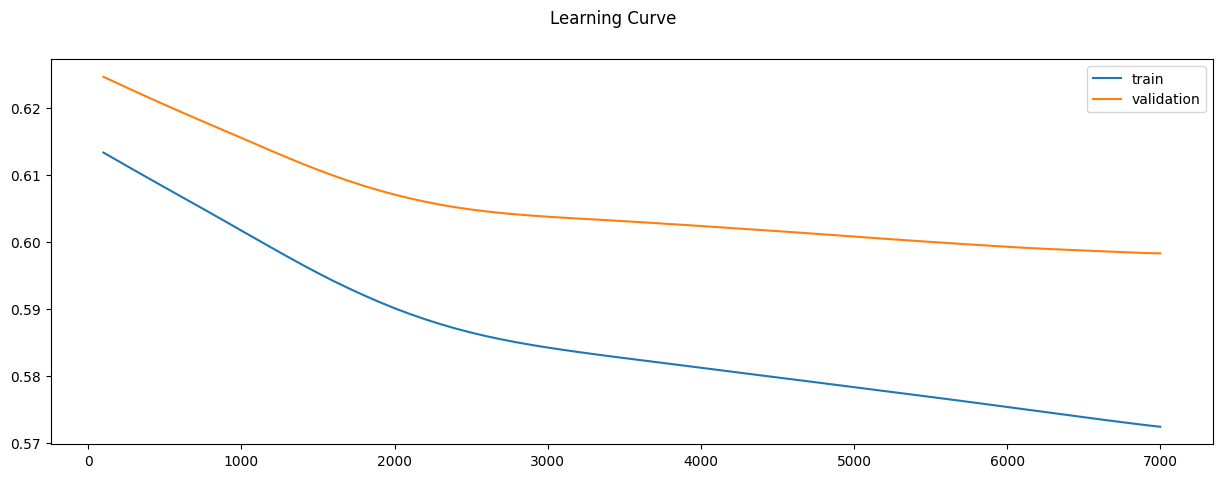

In [16]:
modelTrain.plot_learning_curve(losses)

In [18]:

import sklearn.metrics

r = sklearn.metrics.confusion_matrix(data_splits['y_test'], test_y_pred)
print(r)

torch.Size([1407, 1])